# 7. 앙상블 학습과 랜덤 포레스트

In [2]:
import numpy as np
np.random.seed(42)
import os 
import sklearn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

- 여러개의 예측기로 예측을 수집 => 더 좋은 예측을 할 수 있을것  
    - 여기서 여러개의 예측기를 앙상블이라고 하고, 이 학습을 앙상블 학습이라고 한다.
    - 앙상블 학습 알고리즘 = 앙상블 방법
- 결정 트리의 앙상블 = 랜덤 포레스트(random forest)

# 7.1 투표기반 분류기

#### Hard voting(직접 투표)  
- 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측(다수결 예측)  
    - 각 분류기가 weak learner라도, 앙상블은 strong learner가 될 수 있다.
    - 큰 수의 법칙(law of large numbers)  
        - 많은 앙상블 -> 높은 정확도로 수렴(동전 예시)
---   
#### Tip
- 앙상블 방법은 예측기가 가능한 서로 독립적일 때 최고의 성능을 발휘한다.  
    - 즉, 각기 다른 알고리즘으로 학습시킴 -> 각기 다른 종류의 오차 => 앙상블 모델의 정확도 향상

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
#로지스틱 회귀, 랜덤포레스트, 서포트벡터머신 3개를 앙상블

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard') #hard voting사용

#soft voting을 사용한다면, SVC의 매개변수 probability = True로 설정해야 함!
#서포트벡터머신은 기본적으로 클래스 확률을 제공하지 않기 때문이다.
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score
#각각의 분류기에 대한 테스트셋 정확도 확인

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
#각각의 분류기보다, 앙상블 모델의 정확도가 더 높다.

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### Soft voting(간접투표)  
- 모든 분류기가 클래스의 확률을 예측할 수 있다면 => 개별 분류기의 평균으로 가장 높은 확률의 클래스를 예측하는 것.
    - 직접 투표 방식보다 성능이 높다


# 7.2 배깅과 페이스팅

- 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 다르게 학습시키는 방식으로 앙상블 가능  
    - 배깅(bagging): 훈련세트에서 중복을 허용하여 샘플링하는 방식(부트스트랩핑, bootstrapping)
    - 페이스팅(pasting): 훈련세트에서 중복을 허용하지 않고 샘플링하는 방식
    - 배깅과 페이스팅의 확장성: 병렬 학습을 가능하게 한다.  
      
        
    - 배깅이 페이스팅(부트스트래핑)보다 높은 편향 & 앙상블의 낮은 분산
    - 전반적으로 배깅이 더 나은 모델이긴 하지만 가능하다면 둘 다 해보는게 좋음.
--- 
- 각 분류기 학습 후 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측 실시  
    - 수집함수
            - 분류: 통계적 최빈값 이용  
            - 회귀: 평균 이용

## 7.2.1 사이킷런의 배깅과 페이스팅

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#500개의 트리를 사용한 배깅 앙상블
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42) 
#bootstrap = False로 하면 페이스팅이고
#True로 하면 배깅(부트스트랩핑, bootstrapping)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [7]:
#단일 결정트리를 이용
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


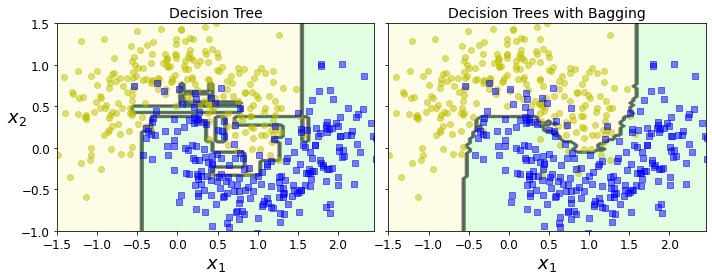

 - 오른쪽이 앙상블 => 일반화 가능성이 더 높다

## 7.2.2. oob 평가

- BaggingClassifier는 디폴트로 배깅을 사용(bootstrap = True)
    - 평균적으로 63%의 훈련 샘플만 샘플링 된다.  
    - 나머지 37%를 oob(out-of-bag)샘플 이라고 한다.(예측기마다 oob는 다르다)
--- 
예측기 훈련동안은 oob사용하지 않고, oob를 검증세트로 사용할 수 있다.
- BaggingClassifier를 만들 때, oob_score = True로 하면 자동으로 oob평가 수행

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, n_jobs = -1, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [9]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
#테스트 세트를 이용한 정확도 검증

0.912

In [10]:
#oob샘플에 대한 결정함수의 값을 확인(훈련샘플에서 각 클래스의 확률을 반환)
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특성 샘플링도 지원
    - max_features, bootstrap_features 두 매개변수로 조절(특성에 대한 샘플링)
    - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련 
--- 
- 특성 샘플링은 매우 고차원의 데이터셋을 다룰 때 유용하다.
    - 랜덤 패치 방식(random patches method): 특성과 샘플을 모두 샘플링 하는 것
    - 랜덤 서브스페이스 방식(random subspaces method): 훈련샘플은 모두 사용 하고, 특성은 샘플링 하는 것
        - bootstrap=False, max_samples=1 => 훈련 샘플 모두 사용
        - bootstrap_features=True, max_features 는 1보다 작게 => 특성 샘플링 사용
--- 
- 특성 샘플링은 더 다양한 예측기를 만들고 편향을 늘리는 대신 분산을 낮춘다.

# 7.4 랜덤 포레스트

- 랜덤 포레스트: 배깅(또는 페이스팅)을 적용한 결정 트리의 앙상블
    - max_sample을 훈련 세트의 크기로 지정
    - RandomForestClassifier(또는 RandomForestRegressor) 사용

In [11]:
from sklearn.ensemble import RandomForestClassifier
#500개의 결정트리로 이루어진 랜덤 포레스트
#최대 16개의 리프노드
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
#여기서 n_jobs는 컴퓨터 코어 사용을 의미한다
     #n_jobs=-1 => 컴퓨터의 모든 코어를 사용 
#RandomForestClassifier는 DecisionTreeClassifier의 매개변수와
#BaggingClassifier의 매개변수를 모두 가지고 있다.
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [12]:
#BaggingClassifier를 사용하여 위 모델과 비슷하게 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
np.sum(y_pred == y_pred_rf) / len(y_pred)
#예측이 거의 동일하다

1.0

## 7.4.1 엑스트라 트리

- 랜덤 포레스트 => 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
    - 임계값을 찾는 것 보다, 후보 특성을 사용해 무작위로 분할 => 최상의 분할을 선택
--- 
- 익스트림 랜덤 트리(extremely randomized trees): 극단적으로 무작위한 트리의 랜덤 포레스트
    - 엑스트라 트리(extra-trees)라고도 한다.
    - 편향이 늘어나지만 분산이 낮아진다.
    - 일반적인 랜덤 포레스트보다 훨씬 빠르다.(일반 랜덤포레스트는 최적의 임계값을 찾는데 오래 걸림)

## 7.4.2 특성중요도

- 랜덤 포레스트: 상대적 중요도를 측정하기 쉽다.
    - 어떤 특성의 노드가 불순도를 얼마나 감소시키는지 확인 => 특성의 중요도 측정.
    - 전체 중요도의 합이 1이 된다.
        - feature_importances_ 변수에 저장

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [15]:
rnd_clf.feature_importances_ #특성의 중요도 확인

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

# 7.5 부스팅

부스팅: weak learner를 여러개 연결하여 strong learner를 만드는 앙상블 방법  
    아이디어: 앞의 모델을 보완해가면서 일련의 예측기 학습시킴  
- AdaBoost(adaptive boosting) 과 Gradient boosting이 있다.

## 7.5.1 에이다부스트

- 원리: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이기
    - 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰진다.

- 경사하강법: 비용함수를 최소하하기 위해 한 예측기의 모델 파라미터를 조정  
- 에이다부스트: 점차 더 좋아지도록 앙상블에 예측기를 추가  
--- 
- 에이다부스트  
    - 모든 예측기가 훈련을 마치면 배깅/페이스팅과 비슷한 방식으로 예측 만듦.
    - 에러율을 사용  
        - 에러율: 직전 예측기에서 오답(예측=/=정답레이블) 가중치를 모든 가중치로 나눈다,,,?
        - 예측기의 가중치 $\alpha_j = \eta log{1-r_j \over r_j}$  
        - 예측기가 정확할수록 가중치가 커지고, 무작위일 때는 가중치=0, 음수도 가능  
        <br><br>
    - 각 샘플의 가중치($w^{(i)}$) 업데이트 방식  
        - 정답일때는 그대로, 오답인 경우 $\exp (\alpha_j)$를 가중치에 곱하여 업데이트  
        - 따라서 오답인 경우 가중치가 더 커지게 된다.
        - 이후에 모든 샘플의 가중치($w^{(i)}$)를 정규화한다.
        - 마지막으로 새 예측기가 업데이트된 가중치를 사용하여 훈련된다.
        - 과정 반복(지정된 예측기 수에 도달할때까지 or 완벽한 예측기가 만들어질때까지)<br><br>
    - 에이다부스트의 예측
         - $\hat y(x) = argmax\sum ^N_{j=1}\alpha_j$
         - 가중치 합이 가장 큰 클래스가 예측 결과(argmax)  
--- 
사이킷런 => SAMME(에이다부스트의 다중 클래스 버전)사용

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
#200개의 결정트리를 앙상블
#학습률 = 0.5, max_depth = 1(결정노드 1개, 리프노드 2개)
ada_clf.fit(X_train, y_train)
#에이다부스트 과대적합 => 예측기 갯수를 줄이거나, 규제를 더 강하게

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

## 7.5.2 그레이디언트 부스팅

- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가  
    - 에이다부스트와 차이점:이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킨다.( 샘플의 가중치 수정X)  
- 결정트리를 사용한 회귀문제 => 그레이디언트 트리 부스팅(그레이디언트 부스티드 회귀 트리, GBRT)

In [24]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [26]:
y2 = y - tree_reg1.predict(X) #첫번째 예측기에서 생긴 잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2) #잔여 오차를 학습시킨다.

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
y3 = y2 - tree_reg2.predict(X) #두번째 예측기에서 생긴 잔여오차
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3) #잔여오차를 학습
#3개의 트리를 포함하는 앙상블 모델 형성

DecisionTreeRegressor(max_depth=2, random_state=42)

In [32]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

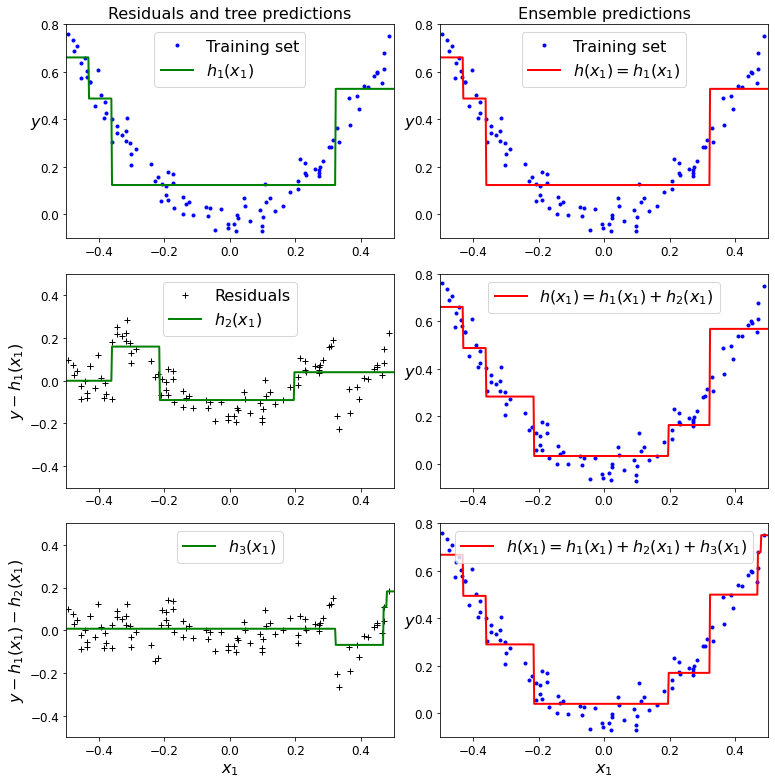

- 왼쪽 열은 세 트리의 예측, 오른쪽은 앙상블의 예측
    - 첫번째 행은 트리가 1개 이므로 완전히 같다.
    - 트리가 앙상블에 추가될수록 예측이 점차 좋아진다.
--- 
사이킷런의 GradientBoostingRegressor를 사용하요 GBRT 앙상블 훈련시키기

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
#n_estimators=3 => 3개의 결정트리
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- 축소: 학습률을 낮게 설정함으로써 앙상블 학습에 많은 트리를 사용하는것.
    - 규제의 방법중 하나.  
    - 작은 학습률 + 많은 트리 => 과대적합 가능성
    - 큰 학습률 + 적은 트리 => 과소적합 가능성  
        - 최적 트리를 찾기 위해 조기종료 사용가능!

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

#트리 120개를 사용한 그레디언트부스팅
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
#MSE를 오차로 사용
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [36]:
min_error = np.min(errors)
#warm_start = True로 설정 ~ 사이킷런에서 fit() 메서드가 호출될 때 
                    #기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.
                            
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
#subsample 매개변수를 활용하여 확률적 그레이디언트 부스팅을 사용할 수 있다.
    #예를 들어 subsample = 0.25를 설정하면
    #각 트리는 무작위로 설정된 25%의 훈련 샘플로 학습된다. 
        #확률적 그레이디언트 부스팅: 속도 높아지고, 분산이 낮아지고, 편향이 높아짐

min_val_error = float("inf") #양의 무한대
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

- XGBoost = Extreme Gradient Boosting
    - 파이썬 라이브러리 제공  
    - 매우 빠른 속도, 확장성, 이식성

In [39]:
!pip install xgboost

In [40]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [41]:
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211


C:\Users\alsrl\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# 7.6 스태킹

- 스태킹(stacking) = stacked generalization  
    - 앙상블에 속한 모든 예측기의 예측을 취합하는 모델을 훈련시킬 수 없을까?
    - 블렌더(blender) 사용(또는 메타 학습기,meta learner)
--- 
- 홀드아웃(hold-out)세트를 사용.
    - 훈련 세트를 두개의 서브셋으로 나눈다.  
    - 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용.
    - 첫번째 레이어의 예측기를 사용하여 두번째 홀드아웃 세트에 대한 예측 생성
    - 이 예측을 입력 특성으로 사용하는 새로운 훈련세트 만듦.
    - 새로운 훈련세트로 블렌더를 훈련.